# Análisis de semántica latente

El análisis de semántica latentente (o <i>Latent Semantic Analysis</i>, LSA) se basa en una matriz de co-ocurrencias de términos en documentos que después se descompone en valores singulares (SVD) para representar mejor las relaciones entre los términos y los documentos.

In [1]:
from nltk.corpus import brown, stopwords
from nltk.stem import SnowballStemmer
from collections import defaultdict, Counter
from itertools import chain
from operator import itemgetter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

### Creación de la matriz de co-ocurrencia

Para crear la matriz de co-ocurrencias, simplemente contamos las veces que un término a parece en un documento, y con eso llenamos una matriz de la forma:

$$A_{i,j} = coocurrence(d_j, t_i)$$

Donde $d_j$ es un documento y $t_i$ un términos.

In [2]:
#Algoritmo de stemming
stemmer = SnowballStemmer('english')
#Función para tratar al token
tokenize = lambda token: stemmer.stem(token.lower())    
#stopwords
stop = stopwords.words('english')

In [3]:
#Recupera ids de ciertos tópicos en el corpus
doc_ids = brown.fileids(categories=['romance'])[:5] + brown.fileids(categories=['religion'])[:5] + brown.fileids(categories=['government'])[:5] #brown.categories())

#Guarda los documentos
documents = defaultdict(list)
for docID in doc_ids:
    #Recupera los tokens
    tokens = brown.words(docID)
    for w in tokens:
        #Guarda los tokens alfanuméricos
        if w.isalpha() != False and w.lower() not in stop:
            documents[docID].append(tokenize(w))
            
Occurrence = pd.DataFrame.from_dict({docID:Counter(terms) for docID,terms in documents.items()}).fillna(0)
Occurrence

,cp01,cp02,cp03,cp04,cp05,cd01,cd02,cd03,cd04,cd05,ch01,ch02,ch03,ch04,ch05
neither,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
like,4.0,10.0,3.0,9.0,4.0,3.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,0.0,2.0
dislik,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
old,16.0,5.0,5.0,9.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
man,15.0,0.0,5.0,7.0,6.0,3.0,1.0,1.0,26.0,0.0,0.0,0.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aggreg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
guard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
harbor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
season,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [4]:
Occurrence['ch02'].sort_values()

yuki           0.0
creation       0.0
accomplish     0.0
analog         0.0
scriptur       0.0
              ... 
aid           17.0
must          20.0
program       25.0
countri       29.0
develop       34.0
Name: ch02, Length: 3744, dtype: float64

Además de la matriz, podemos indexar con un número natural tanto a los términos como a los documentos, para así, poder tener acceso más rápido a las entradas de la matriz.

También obtenemos los tópicos a los que cada documento pertenece.

In [5]:
#Índices de los términos
t_voc = {t:i for i,t in enumerate(Occurrence.index.to_list())}
#Índice de los documentos
d_voc = {d:j for j,d in enumerate(Occurrence.columns.to_list())}
#Tópicos
topic = [brown.categories(d)[0] for d,j in d_voc.items()]

print(len(t_voc), len(d_voc))

3744 15


### Descomposición en valores singulares

La descomposición en valores singulares (SVD) descompone la matriz $A$ de la siguiente forma:

$$A \approx U S V^T$$

Donde $U$ es una matriz de los eigenvectores de $AA^T$, $V$ es una matriz de los eigenvectores de $A^TA$ y $S$ es una matriz diagonal que contiene los eigenvalores de $AA^T$ o $A^TA$, a los que se conoce como valores singulares.

In [6]:
#Descomposición en valores singulares
U,S,V = np.linalg.svd(Occurrence.to_numpy(), full_matrices=False)

print(U.shape, V.shape, S.shape)

(3744, 15) (15, 15) (15,)


La matriz $U$ se dice que representa los términos, pues cada renglón de esta guarda información sobre los términos. Por su parte, $V$ representa los documentos.

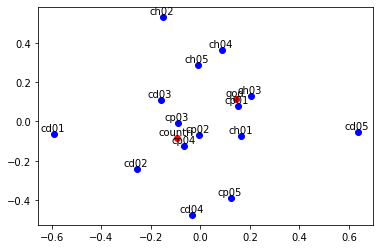

In [7]:
#Reducción de V
pca_d = PCA(n_components=2)
docs = pca_d.fit_transform(V)
#Reducción de U
pca_t = PCA(n_components=2)
terms = pca_d.fit_transform(U)

#Función para visualizar los embeddings
#Usa reducción de la dimensionalidad por PCA
def plot(Z,ids, color='blue'):
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c=color)
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
   # plt.show()

#plot(docs, topic) #list(d_voc.keys()))
plot(docs, list(d_voc.keys()))
plot(terms[[t_voc['countri'],t_voc['god']]], ['countri','god'], color='red')
plt.show()

Con estas nuevas matrices, se puede crear una nueva matriz, elidiendo algunas de los renglones de $U$ y de las columnas de $V$, así como algunos de los valores en $S$. Esta nueva matriz será el producto:

$$\hat{A} = U_k S_k V_k^T$$

$\hat{A}$ tendrá las mismas dimensiones que la matriz $A$, pero sus entradas representarán de forma distinta las relaciones entre términos y documentos.

In [8]:
#Número de dimensiones
k = 10
#Matriz reconstruida con nuevas dimensiones
A_hat = U[:,:k]@np.diag(S[:k])@V[:k,:]

#Matriz de LSA
LSA = pd.DataFrame(data=A_hat, index=list(t_voc.keys()), columns=list(d_voc.keys()))
LSA

,cp01,cp02,cp03,cp04,cp05,cd01,cd02,cd03,cd04,cd05,ch01,ch02,ch03,ch04,ch05
neither,0.665407,0.817965,0.615527,0.758392,0.536954,0.899676,0.455668,0.978671,-0.003448,0.474622,-0.009044,0.937269,-0.071891,-0.005752,0.030841
like,6.335509,7.785316,5.441176,6.960240,4.865641,2.951487,-0.369530,-0.084379,0.695351,1.049441,1.065243,2.098134,3.763458,0.014756,1.960154
dislik,0.396172,0.490776,0.358272,0.407130,0.315175,-0.034854,0.450013,0.013538,0.038438,0.558276,-0.006942,-0.064523,-0.006582,-0.011837,0.002080
old,7.552804,9.317688,6.363341,8.184271,5.388478,-0.123968,-0.769726,0.297675,1.925838,1.540663,-0.029892,-0.030719,1.125574,0.808893,0.100506
man,7.867420,5.388167,5.994974,7.249608,4.788357,2.991685,1.219653,1.317391,26.794751,-0.068616,-0.081819,-0.161875,6.476344,-0.109263,0.138651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aggreg,0.015567,0.000360,-0.012351,-0.012029,0.011170,0.000244,0.000269,0.000095,-0.000450,-0.001136,0.000363,0.000144,-0.000887,-0.000215,0.999332
guard,0.015567,0.000360,-0.012351,-0.012029,0.011170,0.000244,0.000269,0.000095,-0.000450,-0.001136,0.000363,0.000144,-0.000887,-0.000215,0.999332
harbor,0.015567,0.000360,-0.012351,-0.012029,0.011170,0.000244,0.000269,0.000095,-0.000450,-0.001136,0.000363,0.000144,-0.000887,-0.000215,0.999332
season,0.031133,0.000720,-0.024702,-0.024058,0.022341,0.000489,0.000538,0.000191,-0.000899,-0.002271,0.000726,0.000287,-0.001773,-0.000431,1.998665


### Recuperación de información con LSA

Finalmente, el método de LSA nos permite recuperar información a partir de comparar, como un modelo de espacio vectorial los vectores que representan los términos (para la query) y los que representan los documentos.

In [9]:
def sim(terms,d,p=2, boolean='OR'):
    #Obtención de query
    t_vec = np.array([U[t_voc[t]][:k] for t in terms]).sum(0)
    #Vector de documento
    d_vec = V[d_voc[d]][:k]

    #Cálculo de similitud
    if boolean == 'NOT':
        s = (t_vec**p)@(d_vec**p)/(t_vec**p).sum()
        return 1-s**(1/p)
    elif boolean == 'AND':
        s = (t_vec**p)@(1-d_vec**p)/(t_vec**p).sum()
        return 1 - s**(1/p)
    elif boolean == 'OR':
        s = (t_vec**p)@(d_vec**p)/(t_vec**p).sum()
        return s**(1/p)

#Query
term = ['god','spirit']
#documentos y relevancia
ri = []
for d in d_voc.keys():
    #Cálculo de similitud por documento
    s = sim(term, d, boolean='OR')
    ri.append((s,d,brown.categories(d)[0]))
    
#Ordena los resultados por relevancia
sorted(ri, key=itemgetter(0), reverse=True)

[(0.5308296069373574, 'cd01', 'religion'),
 (0.3821595288696004, 'cd02', 'religion'),
 (0.3350469927833563, 'cd05', 'religion'),
 (0.31736770650445756, 'cd03', 'religion'),
 (0.30683411636872343, 'ch02', 'government'),
 (0.2160214639573579, 'ch03', 'government'),
 (0.1918091766352195, 'cp02', 'romance'),
 (0.1818322641890061, 'ch01', 'government'),
 (0.1801415391500703, 'cp03', 'romance'),
 (0.16293285953352157, 'cp05', 'romance'),
 (0.15946086365252324, 'cp01', 'romance'),
 (0.139964123716632, 'ch05', 'government'),
 (0.13944627665593004, 'ch04', 'government'),
 (0.11398374279003307, 'cd04', 'religion'),
 (0.10988959225905665, 'cp04', 'romance')]